In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import Point
import geopandas as gpd

##### Read households and add location point

In [2]:
city_name = 'samara'
data_dir = '../data/initial_' + city_name + '/'
city_districts_file = data_dir + 'districts.geojson'

households = pd.read_csv(data_dir + 'households.txt', sep = '\t')

def generate_point_from_coords(row):
    return Point([row['longitude'], row['latitude'],])

households['location'] = households.apply(generate_point_from_coords, axis=1)

##### Read MO from city and get polygons of them

In [3]:
municipal_districts = gpd.read_file(city_districts_file)
municipal_districts = municipal_districts.rename(columns={'name': 'mo_name'})
municipal_districts = municipal_districts.sort_values(by = ['mo_name'])
municipal_districts

,osm_id,boundary,admin_level,parents,mo_name,local_name,name_en,geometry
6,-283645,administrative,9,"-287507,-72194,-1075831,-60189",Железнодорожный район,Железнодорожный район,None,"MULTIPOLYGON (((50.10364 53.17558, 50.10901 53..."
1,-285953,administrative,9,"-287507,-72194,-1075831,-60189",Кировский район,Кировский район,None,"POLYGON ((50.11259 53.31028, 50.11263 53.30873..."
0,-285954,administrative,9,"-287507,-72194,-1075831,-60189",Красноглинский район,Красноглинский район,None,"POLYGON ((49.73139 53.48063, 49.73146 53.47726..."
8,-283540,administrative,9,"-287507,-72194,-1075831,-60189",Куйбышевский район,Куйбышевский район,None,"POLYGON ((50.00880 53.15115, 50.00896 53.15005..."
5,-283781,administrative,9,"-287507,-72194,-1075831,-60189",Ленинский район,Ленинский район,None,"POLYGON ((50.05825 53.21332, 50.06155 53.21204..."
4,-284542,administrative,9,"-287507,-72194,-1075831,-60189",Октябрьский район,Октябрьский район,None,"POLYGON ((50.07591 53.23816, 50.11718 53.21049..."
2,-285136,administrative,9,"-287507,-72194,-1075831,-60189",Промышленный район,Промышленный район,None,"POLYGON ((50.12675 53.27904, 50.13339 53.27569..."
7,-283541,administrative,9,"-287507,-72194,-1075831,-60189",Самарский район,Самарский район,None,"POLYGON ((49.95306 53.17213, 49.95330 53.16858..."
3,-284582,administrative,9,"-287507,-72194,-1075831,-60189",Советский район,Советский район,None,"POLYGON ((50.18876 53.21401, 50.18901 53.21373..."


In [5]:
from tqdm import tqdm
tqdm.pandas()

def assign_mo_id(row):
    for district, geom in zip(municipal_districts['mo_name'], municipal_districts['geometry']):
        if geom.contains(row['location']):
            return str(district)
        
        
# uncomment next line if you want to create additional column with municipal district id of each household in data - this will take a while       
households['mo_name'] = households.progress_apply(assign_mo_id, axis=1)

100%|██████████| 1158519/1158519 [04:22<00:00, 4413.54it/s]


In [46]:
households.to_csv(data_dir + 'households_with_mo_name_samara.txt', sep = '\t')

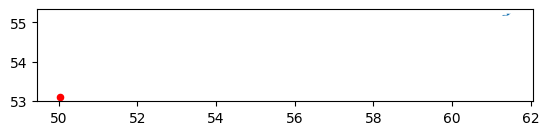

In [47]:
household = households.iloc[10]
household

district = municipal_districts.iloc[3]
mo = gpd.GeoDataFrame(columns=['mo_name', 'geometry'])
mo.loc[0] = district
mo
mo.plot()
plt.scatter(household['longitude'], household['latitude'], s=20, color='red')

In [48]:
households = pd.read_csv('households_with_mo_name_samara.txt', sep='\t', index_col=0)
### SAMPLE FRACTION 
fraction = 0.25
### 

sampled_households_df = pd.DataFrame([])
for mo_id in municipal_districts['mo_name']:
    mo_df = households[households['mo_name'] == mo_id]
    mo_df = mo_df.sample(frac=fraction) # take 5 percents of all apartaments in each municipal district
    sampled_households_df = pd.concat([sampled_households_df, mo_df])
sampled_households_df.to_csv(r'data/samara_25/households_sampled.txt', sep = '\t')

##### Remove people from deleted apartaments

In [49]:
sampled_households_df

,Unnamed: 0,sp_id,hh_size,latitude,longitude,location,mo_name


In [50]:
set_of_households = set()
for sp_id in sampled_households_df['sp_id']:
    set_of_households.add(sp_id)

print("Number of households:", len(set_of_households))
people_df = pd.read_csv(r'data/samara_15km_new/people_samara_2023_final.txt', sep = '\t', index_col=0) 

Number of households: 0


In [51]:
people_sampled = people_df[people_df['sp_hh_id'].isin(set_of_households)]
people_sampled.to_csv(r'data/samara_25/people_sampled.txt', sep = '\t')

In [52]:
import os
import json

set_of_people = set(people_sampled.index.unique())

dict_school_id = json.load(open(os.path.expanduser(
    r'data/samara_15km_new/schools_samara_final.json')))

dict_school_id_sampled = {}
for school in dict_school_id:
    current_list_of_students = []
    children_in_current_school = dict_school_id[school]
    for child in children_in_current_school:
        if child in set_of_people:
            current_list_of_students.append(child)
    dict_school_id_sampled[school] = current_list_of_students
    # if school == '425':
    #     print(current_list_of_students)
            
dict_school_id_sampled 
with open('data/samara_25/schools_sampled.json', 'w') as fp:
    json.dump(dict_school_id_sampled, fp)     
    

In [53]:
dict_school_id

{'201': [20,
  22,
  25,
  39,
  60,
  62,
  64,
  74,
  76,
  79,
  91,
  93,
  102,
  106,
  133,
  137,
  138,
  147,
  163,
  176,
  178,
  180,
  183,
  205,
  207,
  210,
  226,
  229,
  242,
  269,
  285,
  287,
  301,
  311,
  320,
  328,
  349,
  353,
  377,
  380,
  396,
  405,
  407,
  408,
  427,
  437,
  438,
  439,
  440,
  452,
  456,
  464,
  484,
  489,
  491,
  501,
  516,
  523,
  524,
  529,
  530,
  538,
  541,
  544,
  551,
  552,
  553,
  568,
  581,
  582,
  600,
  605,
  606,
  612,
  629,
  644,
  649,
  682,
  690,
  704,
  714,
  719,
  723,
  751,
  762,
  765,
  777,
  792,
  793,
  794,
  795,
  798,
  809,
  812,
  813,
  817,
  827,
  828,
  832,
  835,
  843,
  846,
  895,
  905,
  907,
  910,
  919,
  922,
  923,
  924,
  939,
  955,
  959,
  971,
  977,
  981,
  992,
  993,
  994,
  1007,
  1010,
  1020,
  1029,
  1078,
  1084,
  1102,
  1103,
  1104,
  1105,
  1106,
  1124,
  1132,
  1145,
  1156,
  1158,
  1159,
  1162,
  1166,
  1177,
  1187,
  11